## Mixup 

https://docs.fast.ai/callbacks.mixup.html

"when training with mixup, the final loss (training or validation) will be higher than when training without it, even when the accuracy is far better: a model trained like this will make predictions that are a bit less confident."

Using rotated to hz + OpenCv border

Basic default transforms

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.vision import *
import geopandas as gpd
from resizeimage import resizeimage
import datetime
import uuid
from os import listdir
from os.path import isfile, join
import image_data_aug

In [4]:
torch.cuda.set_device(2)
torch.cuda.current_device()

2

In [5]:
data_dir = Path('data')
colombia_rural = Path('data/stac/colombia/borde_rural')
colombia_soacha = Path('data/stac/colombia/borde_soacha')

In [6]:
guatemala_mixco1 = Path('data/stac/guatemala/mixco_1_and_ebenezer')
guatemala_mixco3 = Path('data/stac/guatemala/mixco_3')

In [7]:
st_lucia_castries = Path('data/stac/st_lucia/castries')
st_lucia_dennery = Path('data/stac/st_lucia/dennery')
st_lucia_gros_islet = Path('data/stac/st_lucia/gros_islet')

In [8]:
COUNTRY='colombia'
REGION='borde_rural'
DATASET = f'{COUNTRY}_{REGION}'
DATASET_PATH=colombia_rural
path=data_dir/f'{COUNTRY}_{REGION}/cropped/'
TRAIN_JSON = f'train-{REGION}.geojson'
TEST_JSON = f'test-{REGION}.geojson'

In [9]:
RETRAIN = True
RESIZE_IMAGES = True

In [10]:
MODEL_NAME='cv_reflect_101_mixup'

In [11]:
NB_NUM='03_8_1'

In [12]:
DATE = datetime.datetime.today().strftime('%Y%m%d')
UID=str(uuid.uuid4())[:8]
print(f'UID: {UID}, DATE: {DATE}')                                                 

UID: 8da0419b, DATE: 20191102


In [13]:
DATE = '20191102'
UID = 'a81b6c9e'

In [14]:
SUB_NUM='9'

In [15]:
img_size=256
bs = 64

In [16]:
train_images=data_dir/f'train/rotated/clipped/{img_size}'
test_images=data_dir/f'test/rotated/clipped/{img_size}'

In [17]:
test_names = get_image_files(test_images)

In [18]:
assert len(test_names)==7325

In [19]:
df_all=pd.read_csv(data_dir/'df_train_all.csv')

In [20]:
df_all.tail()

,id,roof_material,verified,country,region
22548,7a22ddec,healthy_metal,False,st_lucia,gros_islet
22549,7a2f73ea,healthy_metal,False,st_lucia,gros_islet
22550,7a34ffa4,healthy_metal,False,st_lucia,gros_islet
22551,7a41560a,healthy_metal,False,st_lucia,gros_islet
22552,7a283ad0,healthy_metal,False,st_lucia,gros_islet


In [21]:
df_test=pd.read_csv(data_dir/'df_test_all.csv')

In [22]:
df_test.tail()

,id,country,region
7320,7a4f3ff4,st_lucia,dennery
7321,7a4fc578,st_lucia,dennery
7322,7a4ac7b2,st_lucia,dennery
7323,7a47e25e,st_lucia,dennery
7324,7a4e3f78,st_lucia,dennery


In [23]:
assert len(df_test)==7325

In [24]:
df_all.loc[df_all['id'] == '7a204ec4']

,id,roof_material,verified,country,region
12960,7a204ec4,irregular_metal,True,guatemala,mixco_1_and_ebenezer


In [25]:
len(df_all)

22553

To put this in a `DataBunch` while using the [data block API](https://docs.fast.ai/data_block.html), we then need to using `ImageList` (and not `ImageDataBunch`). This will make sure the model created has the proper loss function to deal with the multiple classes.

In [26]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

### setup dataset

In [27]:
np.random.seed(42)
dep_var='roof_material'
src = (ImageList.from_df(path=train_images, df=df_all, cols='id', suffix='.tif')
       .split_by_rand_pct(0.2)
      .label_from_df(cols=dep_var)
      .add_test_folder(test_images))

In [28]:
data = (src.transform(tfms, size=img_size)
        .databunch(bs=bs).normalize(imagenet_stats))

In [29]:
#to check what params object has
#dir(data)

In [30]:
data.label_list

LabelLists;

Train: LabelList (18043 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train/rotated/clipped/256;

Valid: LabelList (4510 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
irregular_metal,healthy_metal,healthy_metal,irregular_metal,healthy_metal
Path: data/train/rotated/clipped/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/256

In [31]:
data.loss_func

FlattenedLoss of CrossEntropyLoss()

`show_batch` still works, and show us the different labels separated by `;`.

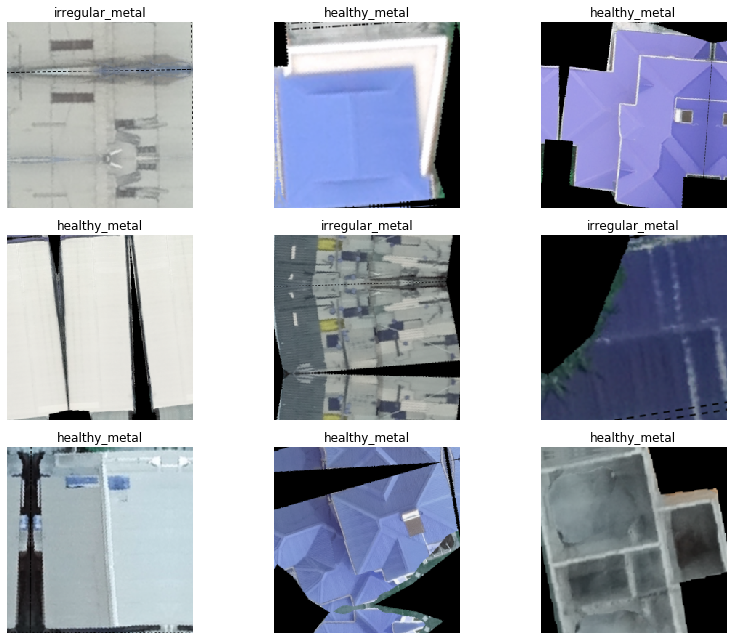

In [32]:
data.show_batch(rows=3, figsize=(12,9))

### Model

In [33]:
arch = models.resnet50
arch_name = 'rn50'

#### with mixup

In [34]:
learn = cnn_learner(data, arch, metrics=error_rate, bn_final=True).to_fp16().mixup()

We use the LR Finder to pick a good learning rate.

### Train model

In [35]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


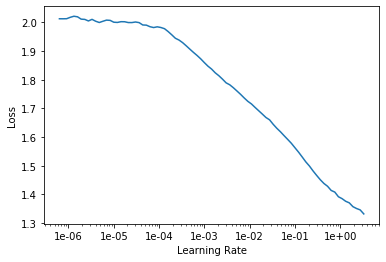

In [36]:
learn.recorder.plot()

Then we can fit the head of our network.

In [37]:
lr = 1e-1

In [38]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,time
0,0.656120,0.522509,0.176497,01:19
1,0.631694,0.573667,0.200000,01:17
2,0.616692,0.475451,0.173171,01:19
3,0.571418,0.385670,0.138359,01:09
4,0.540612,0.380280,0.133925,01:09


Without mixup:
<pre>
epoch 	train_loss 	valid_loss 	error_rate 	time
0 	0.508273 	1.170024 	0.339911 	01:16
1 	0.471699 	0.494651 	0.166297 	01:22
2 	0.439157 	0.417086 	0.152328 	01:23
3 	0.402381 	0.370002 	0.127938 	01:23
4 	0.355355 	0.360440 	0.126608 	01:22
    </pre>

In [40]:
print(f'stage-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

stage-1-rn50-03_8_1-cv_reflect_101_mixup-20191102-a81b6c9e


In [41]:
learn.save(f'stage-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

#### Load model

In [42]:
learn.load(f'stage-1-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

Learner(data=ImageDataBunch;

Train: LabelList (18043 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train/rotated/clipped/256;

Valid: LabelList (4510 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
irregular_metal,healthy_metal,healthy_metal,irregular_metal,healthy_metal
Path: data/train/rotated/clipped/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/256, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    

In [43]:
interp = ClassificationInterpretation.from_learner(learn)
interp.most_confused(min_val=2)

[('irregular_metal', 'healthy_metal', 226),
 ('healthy_metal', 'irregular_metal', 127),
 ('incomplete', 'irregular_metal', 77),
 ('concrete_cement', 'healthy_metal', 36),
 ('other', 'healthy_metal', 36),
 ('incomplete', 'healthy_metal', 18),
 ('concrete_cement', 'irregular_metal', 15),
 ('healthy_metal', 'concrete_cement', 14),
 ('incomplete', 'concrete_cement', 13),
 ('other', 'irregular_metal', 11),
 ('irregular_metal', 'concrete_cement', 10),
 ('irregular_metal', 'incomplete', 9),
 ('concrete_cement', 'incomplete', 5),
 ('healthy_metal', 'incomplete', 4),
 ('irregular_metal', 'other', 2)]

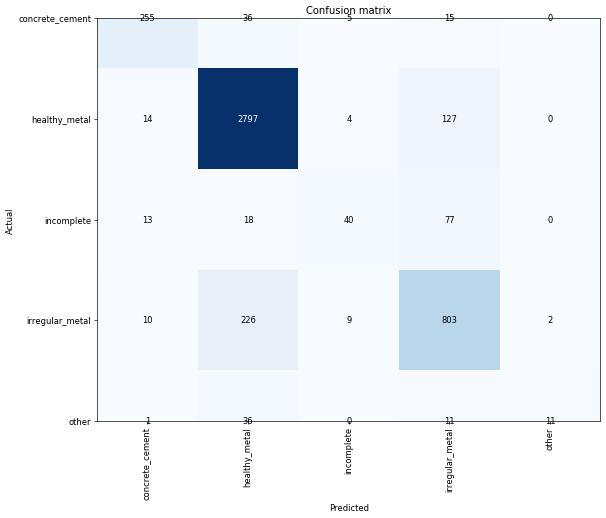

In [44]:
interp.plot_confusion_matrix(figsize=(10,10), dpi=60)

### Re-train

In [45]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


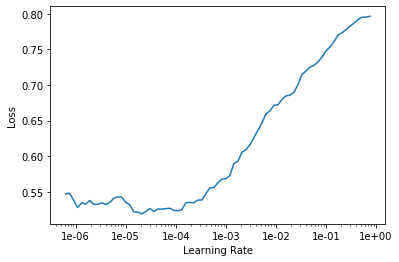

In [46]:
learn.lr_find()
learn.recorder.plot()

In [47]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,error_rate,time
0,0.589391,nan,0.167184,01:24
1,0.600821,0.422965,0.152772,01:27
2,0.572622,0.418924,0.146785,01:24
3,0.551625,0.388065,0.135698,01:15
4,0.552291,0.382863,0.130599,01:13


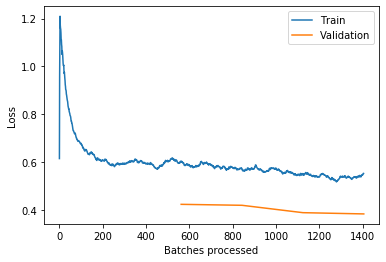

In [48]:
learn.recorder.plot_losses()

In [49]:
learn.save(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

In [50]:
learn.load(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

Learner(data=ImageDataBunch;

Train: LabelList (18043 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
concrete_cement,irregular_metal,healthy_metal,healthy_metal,healthy_metal
Path: data/train/rotated/clipped/256;

Valid: LabelList (4510 items)
x: ImageList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: CategoryList
irregular_metal,healthy_metal,healthy_metal,irregular_metal,healthy_metal
Path: data/train/rotated/clipped/256;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: data/train/rotated/clipped/256, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    

In [51]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,error_rate,time
0,0.560936,0.399985,0.144124,01:12
1,0.574177,nan,0.144568,01:18
2,0.554240,0.388934,0.129047,01:13
3,0.538396,0.379524,0.133038,01:14
4,0.537694,0.389713,0.129047,01:14


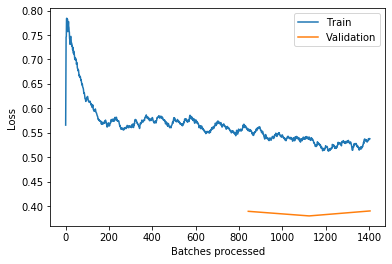

In [52]:
learn.recorder.plot_losses()

In [35]:
learn.save(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}')

In [53]:
learn = learn.to_fp32()

In [54]:
learn.export(f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.pkl')

In [55]:
learn.export()

### inference

In [56]:
#test_images=data_dir/f'test/rotated/clipped/{img_size}'
test_dataset=ImageList.from_folder(test_images)

In [57]:
len(test_dataset)

15325

In [58]:
learn = load_learner(path=data_dir/f'train/rotated/clipped/{img_size}', test=test_dataset)

In [59]:
#learn = load_learner(path=data_dir/f'train/rotated/clipped/{img_size}', file=f'stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.pkl', test=test_dataset)

In [60]:
learn.data.loss_func

FlattenedLoss of CrossEntropyLoss()

In [61]:
type(learn.data)

fastai.vision.data.ImageDataBunch

In [62]:
type(learn.dl(DatasetType.Test))

fastai.basic_data.DeviceDataLoader

In [63]:
len(learn.dl(DatasetType.Test))

240

Get number of items in the Valid dataset (in DeviceDataLoader)

In [64]:
#assert len(learn.dl(DatasetType.Test).dl)==7325

Required format:
    
<pre>
id	concrete_cement	healthy_metal	incomplete	irregular_metal	other
7a4d630a	0.9	0	0	0	0
7a4bbbd6	0.9	0	0	0	0
7a4ac744	0.9	0	0	0	0
7a4881fa	0.9	0	0	0	0
7a4aa4a8	0.9	0	0	0	0
</pre>


In [65]:
preds,y= learn.get_preds(ds_type=DatasetType.Test)

In [66]:
labels = np.argmax(preds, 1)

In [67]:
len(preds)

15325

In [68]:
preds[0].tolist()

[0.03193267062306404,
 0.9569483995437622,
 0.0015251196455210447,
 0.007897553965449333,
 0.0016962597146630287]

In [69]:
preds_list=[]
for pred in preds:
    preds_list.append(pred.tolist())

In [70]:
len(labels)

15325

In [71]:
learn.data.classes

['concrete_cement', 'healthy_metal', 'incomplete', 'irregular_metal', 'other']

In [72]:
data.classes

['concrete_cement', 'healthy_metal', 'incomplete', 'irregular_metal', 'other']

In [73]:
test_predictions = [learn.data.classes[int(x)] for x in labels]

In [74]:
test_predictions[0]

'healthy_metal'

In [75]:
type(learn.data.test_ds)

fastai.data_block.LabelList

In [76]:
 learn.data.test_ds.x.items

array([PosixPath('data/test/rotated/clipped/256/7a4d9168.tif'),
       PosixPath('data/test/rotated/clipped/256/7a4ae922.tif'),
       PosixPath('data/test/rotated/clipped/256/7a48ca98.tif'),
       PosixPath('data/test/rotated/clipped/256/7a49c614.tif'), ...,
       PosixPath('data/test/rotated/clipped/256/sharp_t100/7a468774.tif'),
       PosixPath('data/test/rotated/clipped/256/sharp_t100/7a4b7946.tif'),
       PosixPath('data/test/rotated/clipped/256/sharp_t100/7a4e81f4.tif'),
       PosixPath('data/test/rotated/clipped/256/sharp_t100/7a501f50.tif')], dtype=object)

In [77]:
ids=[]
for item in learn.data.test_ds.x.items:
    base, id = os.path.split(item)
    id = id.split('.tif')[0]
    ids.append(id)

In [78]:
preds_list[0]

[0.03193267062306404,
 0.9569483995437622,
 0.0015251196455210447,
 0.007897553965449333,
 0.0016962597146630287]

In [79]:
cols = learn.data.classes.copy()
cols.insert(0,'id')
df = pd.DataFrame(list(zip(ids, preds_list)), 
               columns =['id', 'pred']) 

In [80]:
cols

['id',
 'concrete_cement',
 'healthy_metal',
 'incomplete',
 'irregular_metal',
 'other']

In [81]:
df.head()

,id,pred
0,7a4d9168,"[0.03193267062306404, 0.9569483995437622, 0.00..."
1,7a4ae922,"[0.009543456137180328, 0.8009838461875916, 0.0..."
2,7a48ca98,"[0.0076043191365897655, 0.2989090383052826, 0...."
3,7a49c614,"[0.004179093986749649, 0.8101887702941895, 0.0..."
4,7a4dd4f2,"[0.00193518097512424, 0.8832339644432068, 0.00..."


In [82]:
pred_df = pd.DataFrame(df['pred'].values.tolist())

In [83]:
pred_df.insert(loc=0, column='id', value=ids)

In [84]:
pred_df.columns = cols

In [85]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other
0,7a4d9168,0.031933,0.956948,0.001525,0.007898,0.001696
1,7a4ae922,0.009543,0.800984,0.009238,0.172886,0.007348
2,7a48ca98,0.007604,0.298909,0.014585,0.676370,0.002532
3,7a49c614,0.004179,0.810189,0.002181,0.175569,0.007882
4,7a4dd4f2,0.001935,0.883234,0.002198,0.101653,0.010980


Required format:
    
<pre>
id	concrete_cement	healthy_metal	incomplete	irregular_metal	other
7a4d630a	0.9	0	0	0	0
7a4bbbd6	0.9	0	0	0	0
7a4ac744	0.9	0	0	0	0
7a4881fa	0.9	0	0	0	0
7a4aa4a8	0.9	0	0	0	0
</pre>


In [86]:
pred_ids=pred_df['id'].values.tolist()

In [87]:
df_baseline = pd.read_csv(data_dir/f'submissions/mean_baseline.csv')

In [88]:
df_baseline.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other
0,7a4d630a,0.093275,0.496369,0.044923,0.352455,0.012979
1,7a4bbbd6,0.093275,0.496369,0.044923,0.352455,0.012979
2,7a4ac744,0.093275,0.496369,0.044923,0.352455,0.012979
3,7a4881fa,0.093275,0.496369,0.044923,0.352455,0.012979
4,7a4aa4a8,0.093275,0.496369,0.044923,0.352455,0.012979


In [89]:
baseline_ids=df_baseline['id'].values.tolist()

In [90]:
assert set(pred_ids)==set(baseline_ids)

#### sort by baseline ids

In [91]:
pred_df['id_cat'] = pd.Categorical(
    pred_df['id'], 
    categories=baseline_ids, 
    ordered=True
)

In [92]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other,id_cat
0,7a4d9168,0.031933,0.956948,0.001525,0.007898,0.001696,7a4d9168
1,7a4ae922,0.009543,0.800984,0.009238,0.172886,0.007348,7a4ae922
2,7a48ca98,0.007604,0.298909,0.014585,0.676370,0.002532,7a48ca98
3,7a49c614,0.004179,0.810189,0.002181,0.175569,0.007882,7a49c614
4,7a4dd4f2,0.001935,0.883234,0.002198,0.101653,0.010980,7a4dd4f2


In [93]:
pred_df=pred_df.sort_values('id_cat')

In [94]:
pred_df.head()

,id,concrete_cement,healthy_metal,incomplete,irregular_metal,other,id_cat
8041,7a4d630a,0.011342,0.978786,0.001311,0.006180,0.002381,7a4d630a
716,7a4d630a,0.011342,0.978786,0.001311,0.006180,0.002381,7a4d630a
764,7a4bbbd6,0.008962,0.956082,0.001407,0.032988,0.000562,7a4bbbd6
8089,7a4bbbd6,0.008962,0.956082,0.001407,0.032988,0.000562,7a4bbbd6
1841,7a4ac744,0.021929,0.907575,0.006809,0.062816,0.000870,7a4ac744


In [95]:
pred_df.drop(columns=['id_cat'],inplace=True)

In [96]:
pred_df=pred_df.drop_duplicates(subset=['id'])

In [97]:
assert len(pred_df)==7325

In [98]:
pred_df.to_csv(data_dir/f'submissions/stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.csv', index=False)

### Submission 10: 0.5215


In [100]:
arch_name = 'rn50'
pred_df=pd.read_csv(data_dir/f'submissions/stage-2-{arch_name}-{NB_NUM}-{MODEL_NAME}-{DATE}-{UID}.csv')

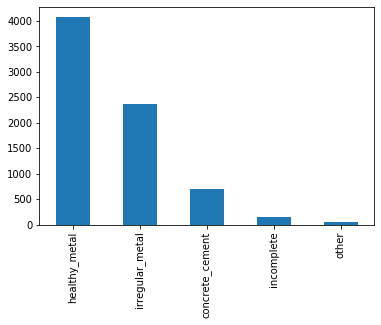

In [101]:
pred_df.drop(columns=['id'],inplace=True)
classes=pred_df.idxmax(axis=1)
pd.value_counts(classes).plot(kind="bar")